In [1]:
 
#basic libs
import numpy as np
import pandas as pd
 
#visualization libs
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
#from jupyterthemes import jtplot
#jtplot.style(theme="monokai",context="notebook",ticks=True,grid=True)
 
#warnings
import warnings
warnings.filterwarnings("ignore")
 
#deep learning libs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,Activation
 
#nlp libs
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.util import *
 
#preprocessing and metrics
from sklearn import metrics,preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
#deep learning libs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,Activation
from tensorflow.keras.callbacks import EarlyStopping

# **Importing the datasets**

In [2]:

#loading the bse sensex  data
df_stock=pd.read_csv("RELIANCE.csv")
#loading the news headlines related to the company
df_news=pd.read_csv("india-news-headlines.csv")

In [3]:
#displaying the stock prices
df_stock.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


In [4]:
#dropping unnecessary columns from stock dataframe
df_stock=df_stock.drop(['Symbol', 'Series','Prev Close','Last','VWAP','Turnover','Trades','Deliverable Volume','%Deliverble'], axis=1)
df_stock.drop(df_stock.index[0:251], inplace=True)
df_stock.head()

,Date,Open,High,Low,Close,Volume
251,2001-01-02,340.35,359.00,340.25,354.30,6623970
252,2001-01-03,355.00,361.70,353.00,360.05,8844088
253,2001-01-04,359.10,366.90,356.20,357.80,5982701
254,2001-01-05,356.50,366.80,356.50,364.30,7460148
255,2001-01-08,362.50,367.45,357.25,360.20,6842731


In [5]:
#displaying the news headlines
df_news.head(5)

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


# **Feature engineering** 

In [6]:
#checking the dimensions of both the datasets
df_stock.shape,df_news.shape

((5055, 6), (3650970, 3))

In [7]:
# dropping the duplicates
df_stock=df_stock.drop_duplicates()

#converting the date column in type "datetime" column
df_stock["Date"]=pd.to_datetime(df_stock["Date"]).dt.normalize()

#filtering the important columns required
df_stock=df_stock.filter(["Date","Open","High","Low","Close","Volume"])

#setting the "Date" as index
df_stock.set_index("Date",inplace=True)

#Sorting the data based on the index
df_stock=df_stock.sort_index(ascending=True,axis=0)

#viewing the dataset
df_stock

,Open,High,Low,Close,Volume
Date,,,,,
2001-01-02,340.35,359.00,340.25,354.30,6623970
2001-01-03,355.00,361.70,353.00,360.05,8844088
2001-01-04,359.10,366.90,356.20,357.80,5982701
2001-01-05,356.50,366.80,356.50,364.30,7460148
2001-01-08,362.50,367.45,357.25,360.20,6842731
...,...,...,...,...,...
2021-04-26,1920.00,1962.00,1911.50,1937.85,9620785
2021-04-27,1940.00,1997.20,1938.25,1988.65,9226547
2021-04-28,1997.85,2008.00,1980.15,1997.30,7902002


### **Stock news data**

In [8]:
# dropping the duplicates
df_news=df_news.drop_duplicates()

#converting the publish_date column in type "datetime" column
df_news["publish_date"]=df_news["publish_date"].astype(str)
df_news["publish_date"]=df_news["publish_date"].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
df_news["publish_date"]=pd.to_datetime(df_news["publish_date"]).dt.normalize()

#fltering the important columns required
df_news=df_news.filter(["publish_date","headline_text"])

#grouping the news according to "Date"
df_news=df_news.groupby(["publish_date"])["headline_text"].apply(lambda x: ','.join(x)).reset_index()

#setting the "publish_Date" as index
df_news.set_index("publish_date",inplace=True)

#Sorting the data based on the index
df_news=df_news.sort_index(ascending=True,axis=0)

#viewing the dataset
df_news

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2022-03-27,Playing a dead man in Body God meant sitting i...
2022-03-28,As fashion becomes democratic; demand for styl...
2022-03-29,Bobby Deol: Like my dad; I hope to be working ...


In [9]:
#concatinating
df=pd.concat([df_news,df_stock],axis=1)

#slicing from 2001-05-22 to 2020-12-31
df=df[pd.Timestamp('2001-05-22'):pd.Timestamp('2020-12-31')]

#dropping null values if anly
df.dropna(axis=0,inplace=True)

#viewing the dataset
df

,headline_text,Open,High,Low,Close,Volume
2001-05-22,"She turned and fought,Re-negotiation best: Des...",377.85,381.50,375.70,377.45,2107258.0
2001-05-25,What Women Want,393.95,397.70,391.05,393.55,4265228.0
2001-05-28,Marriage and work does wonders to Ashutosh Ran...,394.00,401.90,394.00,398.80,2605823.0
2001-05-29,"US visit won't be piece of cake for Krishna,Cy...",399.00,406.95,397.00,403.40,3057001.0
2001-05-30,"Demolition drive: Beware of lake encroachment,...",406.00,406.70,389.95,391.55,3905928.0
...,...,...,...,...,...,...
2020-12-24,How to set the mood for sex during cold winter...,1947.00,1998.80,1945.90,1994.15,9588577.0
2020-12-28,Horoscope Today; 28 December 2020: Check astro...,2006.70,2018.00,1995.30,2003.30,7947719.0
2020-12-29,Man recovers charred remains of 'thief' from h...,2009.00,2012.30,1982.55,1990.05,8589407.0
2020-12-30,Numerology Readings 30 December 2020: Predicti...,1995.25,2007.20,1975.55,1995.50,10173132.0


**Calculating sentiment scores**

In [10]:
#adding the sentiment columns
df["compound"]=""
df["negative"]=""
df["neutral"]=""
df["positive"]=""
df["positive"]=""
df

,headline_text,Open,High,Low,Close,Volume,compound,negative,neutral,positive
2001-05-22,"She turned and fought,Re-negotiation best: Des...",377.85,381.50,375.70,377.45,2107258.0,,,,
2001-05-25,What Women Want,393.95,397.70,391.05,393.55,4265228.0,,,,
2001-05-28,Marriage and work does wonders to Ashutosh Ran...,394.00,401.90,394.00,398.80,2605823.0,,,,
2001-05-29,"US visit won't be piece of cake for Krishna,Cy...",399.00,406.95,397.00,403.40,3057001.0,,,,
2001-05-30,"Demolition drive: Beware of lake encroachment,...",406.00,406.70,389.95,391.55,3905928.0,,,,
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,How to set the mood for sex during cold winter...,1947.00,1998.80,1945.90,1994.15,9588577.0,,,,
2020-12-28,Horoscope Today; 28 December 2020: Check astro...,2006.70,2018.00,1995.30,2003.30,7947719.0,,,,
2020-12-29,Man recovers charred remains of 'thief' from h...,2009.00,2012.30,1982.55,1990.05,8589407.0,,,,
2020-12-30,Numerology Readings 30 December 2020: Predicti...,1995.25,2007.20,1975.55,1995.50,10173132.0,,,,


In [11]:
#calling the required libraries
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui
#keeping track of the progress 
tqdm.pandas()
#instantiating the sentiment analyzer
sid=SentimentIntensityAnalyzer()
#calculating the sentiment scores
df["compound"]=df["headline_text"].progress_apply(lambda x: sid.polarity_scores(x)["compound"])
df["negative"]=df["headline_text"].progress_apply(lambda x: sid.polarity_scores(x)["neg"])
df["neutral"]=df["headline_text"].progress_apply(lambda x: sid.polarity_scores(x)["neu"])
df["positive"]=df["headline_text"].progress_apply(lambda x: sid.polarity_scores(x)["pos"])

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
100%|██████████████████████████████████████████████████████████████████████████████| 4867/4867 [11:43<00:00,  6.92it/s]


In [12]:
#viewing the dataset
df

,headline_text,Open,High,Low,Close,Volume,compound,negative,neutral,positive
2001-05-22,"She turned and fought,Re-negotiation best: Des...",377.85,381.50,375.70,377.45,2107258.0,-0.9907,0.134,0.800,0.066
2001-05-25,What Women Want,393.95,397.70,391.05,393.55,4265228.0,0.0772,0.000,0.606,0.394
2001-05-28,Marriage and work does wonders to Ashutosh Ran...,394.00,401.90,394.00,398.80,2605823.0,-0.9979,0.135,0.807,0.059
2001-05-29,"US visit won't be piece of cake for Krishna,Cy...",399.00,406.95,397.00,403.40,3057001.0,-0.9584,0.081,0.847,0.072
2001-05-30,"Demolition drive: Beware of lake encroachment,...",406.00,406.70,389.95,391.55,3905928.0,-0.5713,0.073,0.850,0.077
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,How to set the mood for sex during cold winter...,1947.00,1998.80,1945.90,1994.15,9588577.0,-0.9971,0.082,0.854,0.064
2020-12-28,Horoscope Today; 28 December 2020: Check astro...,2006.70,2018.00,1995.30,2003.30,7947719.0,-0.9997,0.126,0.789,0.085
2020-12-29,Man recovers charred remains of 'thief' from h...,2009.00,2012.30,1982.55,1990.05,8589407.0,-0.9998,0.136,0.774,0.090
2020-12-30,Numerology Readings 30 December 2020: Predicti...,1995.25,2007.20,1975.55,1995.50,10173132.0,-0.9998,0.126,0.797,0.077


**Writing the finalized data to a disk**

In [13]:

#dropping the headline_text because it's unwanted now
df.drop(["headline_text"],axis=1,inplace=True)
#displaying the data
df

,Open,High,Low,Close,Volume,compound,negative,neutral,positive
2001-05-22,377.85,381.50,375.70,377.45,2107258.0,-0.9907,0.134,0.800,0.066
2001-05-25,393.95,397.70,391.05,393.55,4265228.0,0.0772,0.000,0.606,0.394
2001-05-28,394.00,401.90,394.00,398.80,2605823.0,-0.9979,0.135,0.807,0.059
2001-05-29,399.00,406.95,397.00,403.40,3057001.0,-0.9584,0.081,0.847,0.072
2001-05-30,406.00,406.70,389.95,391.55,3905928.0,-0.5713,0.073,0.850,0.077
...,...,...,...,...,...,...,...,...,...
2020-12-24,1947.00,1998.80,1945.90,1994.15,9588577.0,-0.9971,0.082,0.854,0.064
2020-12-28,2006.70,2018.00,1995.30,2003.30,7947719.0,-0.9997,0.126,0.789,0.085
2020-12-29,2009.00,2012.30,1982.55,1990.05,8589407.0,-0.9998,0.136,0.774,0.090
2020-12-30,1995.25,2007.20,1975.55,1995.50,10173132.0,-0.9998,0.126,0.797,0.077


In [14]:
#writing it to the disk
df.to_csv("finalized_stock_data.csv")

**checking the finalized data**

In [15]:
#shape
df.shape

(4867, 9)

In [16]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4867 entries, 2001-05-22 to 2020-12-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      4867 non-null   float64
 1   High      4867 non-null   float64
 2   Low       4867 non-null   float64
 3   Close     4867 non-null   float64
 4   Volume    4867 non-null   float64
 5   compound  4867 non-null   float64
 6   negative  4867 non-null   float64
 7   neutral   4867 non-null   float64
 8   positive  4867 non-null   float64
dtypes: float64(9)
memory usage: 380.2 KB


In [17]:
#checking for missing values
df.isna().sum()

Open        0
High        0
Low         0
Close       0
Volume      0
compound    0
negative    0
neutral     0
positive    0
dtype: int64

In [18]:

#data description
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,4867.0,1.045722e+03,5.535510e+02,209.9,7.438500e+02,9.610000e+02,1.258025e+03,3298.00
High,4867.0,1.060354e+03,5.631445e+02,224.6,7.539000e+02,9.712500e+02,1.275000e+03,3298.00
Low,4867.0,1.029513e+03,5.413572e+02,203.6,7.348000e+02,9.490000e+02,1.240025e+03,3141.30
Close,4867.0,1.044385e+03,5.519803e+02,206.6,7.429750e+02,9.593000e+02,1.258250e+03,3220.85
Volume,4867.0,5.430967e+06,4.962659e+06,52820.0,2.787826e+06,4.131114e+06,6.374293e+06,65230894.00
compound,4867.0,-8.893865e-01,4.238417e-01,-1.0,-9.998000e-01,-9.992000e-01,-9.952000e-01,1.00
negative,4867.0,1.273088e-01,2.274779e-02,0.0,1.140000e-01,1.280000e-01,1.420000e-01,0.40
neutral,4867.0,7.860588e-01,3.143668e-02,0.0,7.660000e-01,7.820000e-01,8.030000e-01,1.00
positive,4867.0,8.662831e-02,1.883146e-02,0.0,7.600000e-02,8.700000e-02,9.700000e-02,0.60


# **EDA of the finalized stock data**

**Visualizing the opening and closing prices of the stock**

Text(0.5, 1.0, 'Closing prices')

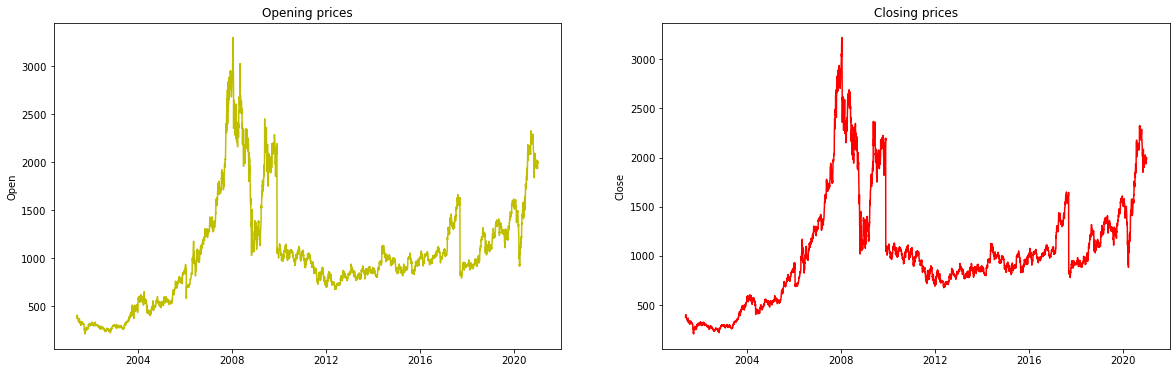

In [19]:
fig,ax=plt.subplots(1,2,figsize=(20,6))
sns.lineplot(data=df,x=df.index,y="Open",ax=ax[0],color="y").set_title("Opening prices")
sns.lineplot(data=df,x=df.index,y="Close",ax=ax[1],color="r").set_title("Closing prices")


# **Data preprocessing for modelling**

In [20]:
#splitting the data into input and target variables
x=df
y=df["Close"]
#splitting the data into train set and test set
training_set=x.iloc[:4000].values
test_set=x.iloc[4000:].values

In [21]:

#scaling the input features with the help of standard scaler
sc=MinMaxScaler()
training_set_scaled=sc.fit_transform(training_set)
test_set_scaled=sc.fit_transform(test_set)

In [22]:

# the model will look into past 100 timesteps predict the next feature and will continue to do so
length=100
#the training set creation
x_train=[]
y_train=[]
for i in range(length,len(training_set)):
    x_train.append(training_set_scaled[i-length:i,0])
    y_train.append(training_set_scaled[i,0])
#converting train set into array
x_train,y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))


# The testing set creation
x_test=[]
y_test=[]
for i in range(length,len(test_set)):
    x_test.append(test_set_scaled[i-length:i,0])
    y_test.append(test_set_scaled[i,0])
# converting test set into array
x_test,y_test=np.array(x_test),np.array(y_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [23]:
#checking the shape of the created datastructures
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((3900, 100, 1), (3900,), (767, 100, 1), (767,))

# **Modelling**

In [24]:
# setting the model architecture
model=Sequential()
model.add(LSTM(units=100,return_sequences=True,input_shape=(x_train.shape[1], 1),activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True,activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=False,activation="tanh"))
model.add(Dropout(0.2))
model.add(Dense(1))
#printing model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 100)          80400     
                                                                 
 dropout_1 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [25]:
# introducing early stopping if val loss doesn't go down for 4 iterations
es=EarlyStopping(monitor="val_loss",patience=4,mode="min")
#compiling
model.compile(optimizer="adam",loss="mse")
#fitting the model
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=22,shuffle=False,callbacks=[es])

Epoch 1/10
178/178 [==============================] - 51s 242ms/step - loss: 0.0064 - val_loss: 0.0479
Epoch 2/10
178/178 [==============================] - 39s 221ms/step - loss: 0.0088 - val_loss: 0.0427
Epoch 3/10
178/178 [==============================] - 39s 220ms/step - loss: 0.0070 - val_loss: 0.0202
Epoch 4/10
178/178 [==============================] - 40s 224ms/step - loss: 0.0025 - val_loss: 0.0132
Epoch 5/10
178/178 [==============================] - 40s 223ms/step - loss: 0.0020 - val_loss: 0.0113
Epoch 6/10
178/178 [==============================] - 40s 227ms/step - loss: 0.0018 - val_loss: 0.0095
Epoch 7/10
178/178 [==============================] - 40s 223ms/step - loss: 0.0016 - val_loss: 0.0081
Epoch 8/10
178/178 [==============================] - 38s 214ms/step - loss: 0.0016 - val_loss: 0.0090
Epoch 9/10
178/178 [==============================] - 38s 213ms/step - loss: 0.0021 - val_loss: 0.0096
Epoch 10/10
178/178 [==============================] - 39s 218ms/step - l

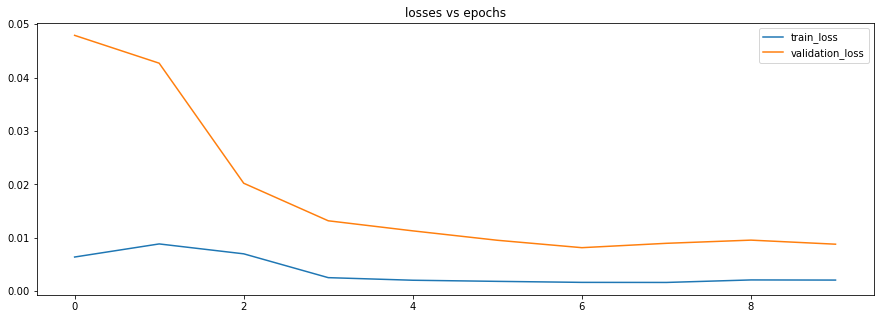

In [26]:
#creating the dataframe contaning the validation loss and  train_inver_transform
loss=pd.DataFrame(model.history.history)
plt.figure(figsize=(15,5))
plt.plot(loss)
plt.title("losses vs epochs")
plt.legend(["train_loss","validation_loss"])

In [27]:
#saving model to the disk as json file
model_json=model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

#serialize weights to HDF5
model.save_weights("model.h5")
print("model saved to the disk")

model saved to the disk


In [28]:
#predicting through the model
pred=model.predict(x_test)

24/24 [==============================] - 4s 77ms/step


In [29]:
#checking the scales and comparing it with our closing price column
sc.scale_,df_stock

(array([6.52209359e-04, 6.34537898e-04, 6.52975938e-04, 6.47815243e-04,
        1.55242233e-08, 5.00075011e-01, 7.75193798e+00, 7.19424460e+00,
        1.23456790e+01]),
                Open     High      Low    Close   Volume
 Date                                                   
 2001-01-02   340.35   359.00   340.25   354.30  6623970
 2001-01-03   355.00   361.70   353.00   360.05  8844088
 2001-01-04   359.10   366.90   356.20   357.80  5982701
 2001-01-05   356.50   366.80   356.50   364.30  7460148
 2001-01-08   362.50   367.45   357.25   360.20  6842731
 ...             ...      ...      ...      ...      ...
 2021-04-26  1920.00  1962.00  1911.50  1937.85  9620785
 2021-04-27  1940.00  1997.20  1938.25  1988.65  9226547
 2021-04-28  1997.85  2008.00  1980.15  1997.30  7902002
 2021-04-29  2022.90  2044.50  2007.30  2024.05  8035915
 2021-04-30  2008.50  2036.00  1987.55  1994.50  9150974
 
 [5055 rows x 5 columns])

In [30]:
# the 4th column is "close" so we should scale our values by the 4th value(corresponding value) in the scale array
scale=1/6.47815243e-04
#scaling the predicted values
pred=pred*scale
#scaling the test values
test=y_test*scale

In [31]:
#creating the dataframe of test values vs predicted values
test_vs_pred=pd.DataFrame(columns=["test","pred"])
test_vs_pred["test"]=test
test_vs_pred["pred"]=pred.flatten()
#checking the dataframne created
test_vs_pred.head(10)

,test,pred
0,156.554753,146.457611
1,159.172389,157.078812
2,151.118125,165.955383
3,150.715412,171.791534
4,133.600101,174.689575
5,122.575828,173.531265
6,110.041379,168.280731
7,119.052087,159.371597
8,139.238086,149.848129
9,143.063861,143.702408


Text(700, 400, 'MSE:20954.43')

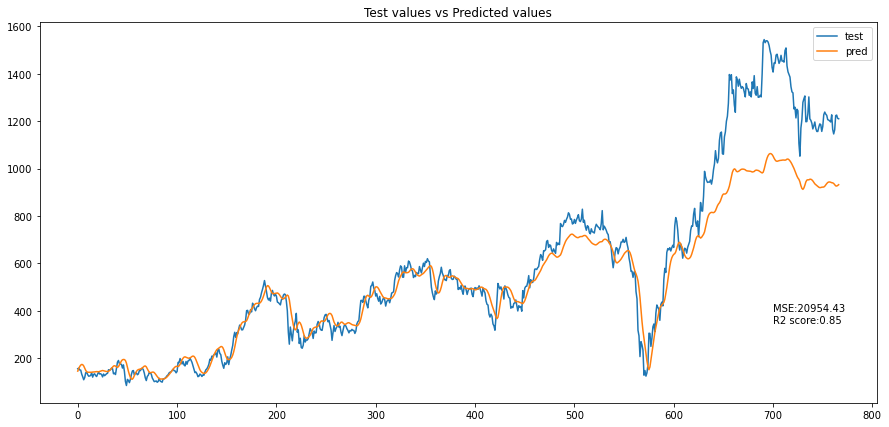

In [36]:
#the lineplot
plt.figure(figsize=(15,7))
plt.plot(test_vs_pred)
plt.title("Test values vs Predicted values")
plt.legend(["test","pred"])
#calculating the losses
r2=np.round(r2_score(test,pred),2)
mse=np.round(mean_squared_error(test,pred),2)
#incorporating the losses in the plot
plt.text(x=700,y=350,s="R2 score:{}".format(r2))
plt.text(x=700,y=400,s="MSE:{}".format(mse))

In [33]:
r2

0.85